In [1]:
import sys
sys.path.insert(0, "../netml/src/")
import pandas as pd
import numpy as np
from netml.pparser.parser import PCAP
import json
import re
import ast
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
import os, glob
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

ModuleNotFoundError: No module named 'netml'

In [668]:
%run "../scripts/helper_functions.py"

In [ ]:
#print(webrtc_files[0])
webrtc_file = "../logs_Teams_06-01/webrtc/393_223_199821_99544_32_1654119261.json"
get_webrtc(webrtc_file)

In [648]:
for k in file_map:
    df_net = file_map[k]["pcap"]
    for interval in [1, 2]:
        get_net_stats_rolling(df_net, interval=interval).head(5)

## Read Data 

In [903]:
data = {}

In [977]:
vca = "Teams"
dirlist = glob.glob(f"../logs_{vca}*")
print(dirlist)
ip = '192.168.1.107'
webrtc_files = []
for dirname in dirlist:
    webrtc_files += glob.glob(f"{dirname}/webrtc/*.json")
cols= ['frame.time_relative','frame.time_epoch','ip.src','ip.dst','ip.proto','ip.len','udp.srcport','udp.dstport', 'udp.length','rtp.ssrc','rtp.timestamp','rtp.seq','rtp.p_type', 'rtp.marker','rtp.padding','rtp.ext','rtp.ext.len','rtcp.pt','rtcp.senderssrc','rtcp.ssrc.high_seq','rtcp.ssrc.dlsr','rtcp.psfb.fmt', 'rtcp.rtpfb.fmt','rtcp.sender.octetcount']

['../logs_Teams_06-01', '../logs_Teams_06-15_rush_hour', '../logs_Teams_06-15_rush_hour.zip', '../logs_Teams_06-01.zip']


510


In [985]:
def get_dirname(x):
    for dirname in dirlist:
        if dirname in x:
            return dirname
file_map = {}
for webrtc_filename in webrtc_files:
    pref = os.path.basename(webrtc_filename)
    dirname = get_dirname(webrtc_filename)
    net_filename = f"{dirname}/capture/{pref[:-4]}csv"
    if not os.path.exists(net_filename):
        print("network file does not exist %s" % net_filename)
        continue

    df_webrtc = get_webrtc(webrtc_filename)
    if df_webrtc.empty:
        continue
    
    df_net = pd.read_csv(net_filename, header=None, sep='\t', names=cols)
    df_net = df_net[(df_net["ip.dst"] == ip) & (~pd.isna(df_net["rtp.ssrc"]))]
    
    if df_net.empty:
        continue
    
    time_col = "frame.time_epoch"
    
    
    #dur = df_net[time_col].max() - df_net[time_col].min()
    #if dur > 150:
    #    continue
    
    df_rtp = df_net[~pd.isna(df_net["rtp.p_type"])]
    #df_rtp =  df_net[df_net["rtp.p_type"] == "98"]
    
    (webrtc_min_time, webrtc_max_time) = (df_webrtc["ts"].min(), df_webrtc["ts"].max())
    (pcap_min_time, pcap_max_time) = (df_rtp[time_col].min(), df_rtp[time_col].max())
   
    if webrtc_max_time < pcap_min_time or pcap_max_time < webrtc_min_time:
        continue
    #df_netml = get_net_stats(df_net)
    file_map[pref] = {"webrtc": df_webrtc, "pcap": df_net, "rtp": df_rtp, "file": webrtc_filename} 
data[vca] = file_map

In [1160]:
print(file_map[k]['pcap'].columns)

Index(['frame.time_relative', 'frame.time_epoch', 'ip.src', 'ip.dst',
       'ip.proto', 'ip.len', 'udp.srcport', 'udp.dstport', 'udp.length',
       'rtp.ssrc', 'rtp.timestamp', 'rtp.seq', 'rtp.p_type', 'rtp.marker',
       'rtp.padding', 'rtp.ext', 'rtp.ext.len', 'rtcp.pt', 'rtcp.senderssrc',
       'rtcp.ssrc.high_seq', 'rtcp.ssrc.dlsr', 'rtcp.psfb.fmt',
       'rtcp.rtpfb.fmt', 'rtcp.sender.octetcount', 'is_rtp', 'time_win',
       'is_video_udp'],
      dtype='object')


In [1200]:
df_net = pd.concat([file_map[k]['rtp'] for k in file_map]).reset_index()
df_net["is_video"] = df_net["rtp.p_type"].apply(lambda x: is_video_rtp(x, vca=vca))
df_net = df_net[df_net["is_video"] == 1]
print(df_net.shape)

(2411171, 27)


<AxesSubplot:xlabel='rtp.ext.len', ylabel='Proportion'>

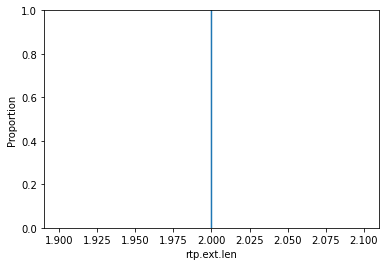

In [1201]:
sns.ecdfplot(df_net['rtp.ext.len'])

In [1202]:
df_net['rtp.padding'].value_counts()

0.00    2411171
Name: rtp.padding, dtype: int64

## Functions

In [1177]:
def is_freeze(x):
    if x["frame_dur"] > max(3*x["avg_frame_dur"], (x["avg_frame_dur"] + 0.150)):
        return 1
    else:
        return 0

def get_freeze_dur(x):
    if x["is_freeze"] == 1:
        return x["frame_dur"]
    else:
        return 0

def get_rtp_len(x):
    return (x['udp.length'] - 12 - x['rtp.ext.len'] - x['rtp.padding'])
    
    
def get_rtp_stats(df_rtp, vca="Meet"):
    ptype = "98" ## for Meet
    if vca == "Teams":
        ptype = 127
    
    df_video = df_rtp[df_rtp["rtp.p_type"] == ptype]
    ## aggregate packets by rtp timestamp
    df_video = df_video.sort_values(["rtp.seq"])
    
    df_video['rtp.length'] = df_video.apply(get_rtp_len, axis=1)
    df_video["rtp.seq_diff"] = df_video["rtp.seq"].diff() - 1
    
    df_video = df_video.groupby("rtp.timestamp").agg({"rtp.length": "sum", 
                                                      "rtp.seq_diff": "sum", 
                                                      "frame.time_epoch": ["min", "max"]}).reset_index()
    df_video.columns = ['_'.join(col).strip('_') for col in df_video.columns.values]
    df_video = df_video.rename(columns={'rtp.length_sum': f'frame_size',
                                       'rtp.seq_diff_sum': 'pkt_loss'})
    df_video["lost_frame"] = df_video["pkt_loss"].apply(lambda x: 0 if x == 0 else 1)
    
    ## frame duration calculations
    df_video["frame_dur"] = df_video["frame.time_epoch_max"].diff()
    df_video["avg_frame_dur"] = df_video["frame_dur"].rolling(30).mean()
    df_video = df_video.dropna()
    
    ## freeze calculation
    df_video["is_freeze"] = df_video.apply(is_freeze, axis=1)
    df_video["freeze_dur"] = df_video.apply(get_freeze_dur, axis=1)
    
    return df_video

def get_per_second_stats(df_video):
    ## obtain per second stats
    df_video[f"ft_end"] = df_video['frame.time_epoch_max'].apply(lambda x: int(x))
    df_grp = df_video.groupby("ft_end").agg({"frame_size" : ["count", "sum"], "is_freeze": "sum", 
                                             "freeze_dur": "sum", 'lost_frame': 'sum',
                                            "frame_dur": "std"}).reset_index()
    
    ## rename columns
    df_grp.columns = ['_'.join(col).strip('_') for col in df_grp.columns.values]    
    df_grp = df_grp.rename(columns={'frame_size_count': 'fps',
                                    'is_freeze_sum': 'freeze_count',
                                    'frame_size_sum': 'bitrate',
                                    'freeze_dur_sum': 'freeze_dur',
                                    'lost_frame_sum': 'frames_lost',
                                    'frame_dur_std': 'interframe_delay_std'
                                   })
    df_grp['bitrate'] = df_grp['bitrate']*8/1000    
    return df_grp


def is_video_udp(x, vca="Meet"):
    if vca == "Meet":
        if x <= 170 or (x >= 266 and x <= 274):
            return 0
        else:
            return 1
    elif vca == "Teams":
        if x <= 178 or (x > 302 and x < 305):
            return 0
        else:
            return 1
        
def is_video_rtp(x, vca="Meet"):
    if vca == "Meet":
        if x != "98":
            return 0
        else:
            return 1
    elif vca == "Teams":
        if x != 127:
            return 0
        else:
            return 1
        
        
size_diff_thresh = {"Meet": 20, "Teams": 1}
def get_frames_udp(df, vca="Meet"):
    col_num = []
    if vca == "Teams":
        df = df[df["udp.length"] != 76]
    
    df["size_diff"] = df["udp.length"].diff().abs()
    last_frame = 0
    for i in range(0, df.shape[0]):
        size_diff = df.iloc[i]["size_diff"]
        if size_diff > size_diff_thresh[vca]:
            col_num.append(i)
            last_frame = i
        else:
            col_num.append(last_frame)
    df["frame_num"] = col_num
    
    df_grp = df.groupby("frame_num").agg({"frame.time_epoch": list, "udp.length": list}).reset_index()
    df_grp["frame_st"] = df_grp["frame.time_epoch"].apply(lambda x: min(x))
    df_grp["frame_et"] = df_grp["frame.time_epoch"].apply(lambda x: max(x))
    df_grp["frame_size"] = df_grp["udp.length"].apply(lambda x: sum(x))
    
    df_grp[f"ft_end"] = df_grp['frame_et'].apply(lambda x: int(x))
    
    
    ## frame duration calculations
    df_grp["frame_dur"] = df_grp["frame_et"].diff()
    df_grp["avg_frame_dur"] = df_grp["frame_dur"].rolling(30).mean()
    df_grp = df_grp.dropna()
    
    ## freeze calculation
    df_grp["is_freeze"] = df_grp.apply(is_freeze, axis=1)
    df_grp["freeze_dur"] = df_grp.apply(get_freeze_dur, axis=1)
    
    
    
    df_grp = df_grp.groupby("ft_end").agg({"frame_size" : ["count", "sum"], "is_freeze": "sum", 
                                             "freeze_dur": "sum", 
                                            "frame_dur": "std"}).reset_index()
    
    ## rename columns
    df_grp.columns = ['_'.join(col).strip('_') for col in df_grp.columns.values]    
    df_grp = df_grp.rename(columns={'frame_size_count': 'fps',
                                    'is_freeze_sum': 'freeze_count',
                                    'frame_size_sum': 'bitrate',
                                    'freeze_dur_sum': 'freeze_dur',
                                    'frame_dur_std': 'interframe_delay_std'
                                   })
    df_grp['bitrate'] = df_grp['bitrate']*8/1000 
    #print(df_grp['ft_end'].head(2))
    return df_grp

def get_udp_per_second_stats(df, vca="Meet"):
    df["is_video_udp"] = df["udp.length"].apply(is_video_udp, vca=vca)
    df_video = df[df["is_video_udp"] == 1]
    df_grp = get_frames_udp(df_video, vca=vca)
    return df_grp
    
    

## Evaluation: Variable initialization

In [1039]:
data_merge_rtp = {}
data_merge_udp = {}
models_vca = {}
netml_data_vca = {}

## Change VCA for RTP/NetML/Evaluation

In [1249]:
vca = "Teams"
file_map = data[vca]
train_files = [x for x in file_map if 'rush_hour' not in file_map[x]['file']]
test_files = [x for x in file_map if 'rush_hour' in file_map[x]['file']]
#train_files, test_files = train_test_split(files)

## RTP Prediction

In [1198]:
webrtc_cols = ["framesPerSecond","lastPacketReceivedTimestamp","ts", "framesReceived",
              'totalFreezesDuration*', 'freezeCount*', '[bytesReceived_in_bits/s]', 'bitrate_gt',
              '[interFrameDelayStDev_in_ms]', 'interFrameDelayStDev_in_s']
dfs_udp = []
dfs_rtp = []
i = 0

for k in test_files:
    i += 1
    if i % 20 == 0:
        print(k)
    
    df_webrtc = file_map[k]['webrtc']
    df_webrtc["bitrate_gt"] = df_webrtc['[bytesReceived_in_bits/s]'] / 1000
    df_webrtc["interFrameDelayStDev_in_s"] = df_webrtc['[interFrameDelayStDev_in_ms]'] / 1000
    df_webrtc = df_webrtc[webrtc_cols]
    
    
    df_grp_udp = get_udp_per_second_stats(file_map[k]['pcap'], vca=vca)
    df_merge_udp = pd.merge(df_grp_udp, df_webrtc, left_on="ft_end", right_on="ts")
    df_merge_udp["file"] = k
    dfs_udp.append(df_merge_udp)
    
    df_video = get_rtp_stats(file_map[k]['rtp'], vca=vca)
    df_grp_rtp = get_per_second_stats(df_video)
    df_merge_rtp = pd.merge(df_grp_rtp, df_webrtc, left_on="ft_end", right_on="ts")
    df_merge_rtp["file"] = k
    dfs_rtp.append(df_merge_rtp)
    
df_merge_rtp = pd.concat(dfs_rtp).reset_index(drop=True)
df_merge_udp = pd.concat(dfs_udp).reset_index(drop=True)

data_merge_rtp[vca] = df_merge_rtp
data_merge_udp[vca] = df_merge_udp

708_148_95981_10_50_1655421830.json
956_340_95889_56056_53_1655417483.json
162_165_2472_644_42_1655402272.json
2549_440_43726_11019_55_1655402791.json
444_123_81804_15785_53_1655416248.json
1862_430_101559_39398_44_1655404065.json
2620_640_49643_9903_39_1655419023.json
1187_734_20442_2369_44_1655402688.json
4548_961_8452_20_43_1655418495.json
3598_2589_22282_5607_46_1655415833.json
507_297_156526_22061_54_1655398230.json
184_16_227454_272369_48_1655399777.json


## NetML

In [964]:
interval_list = range(1, 10)
cols_x = ['bitrate_kbps', 'pktrate_pps',
       'size_min', 'size_max', 'size_mean', 'size_std', 'size_q1', 'size_q2',
       'size_q3', 'iat_min', 'iat_max', 'iat_mean', 'iat_std', 'iat_q1',
       'iat_q2', 'iat_q3']

cols_y = ['framesPerSecond', 'bitrate_gt', 'freezeCount*', 'totalFreezesDuration*', 'interFrameDelayStDev_in_s']
col_y = 'framesPerSecond'
col_map = {'fps': 'framesPerSecond', 'freeze_dur': 'totalFreezesDuration*',
          'bitrate': 'bitrate_gt', 'freeze_count': 'freezeCount*',
          'interframe_delay_std': 'interFrameDelayStDev_in_s'}

In [1216]:
webrtc_cols = ["framesPerSecond","lastPacketReceivedTimestamp","ts", "framesReceived", 
               '[bytesReceived_in_bits/s]', 'freezeCount*', 'totalFreezesDuration*', 
               "interFrameDelayStDev_in_s", "bitrate_gt", '[interFrameDelayStDev_in_ms]']
pred = {}
i = 0
result_map = {}

agg_func = {col: "mean" for col in cols_y}
agg_func["ts"] = "max"
models = {}
netml_data = {}
for interval in interval_list:
    models[interval] = {}
    netml_data[interval] = {}
    print("interval", interval)
    dfs = []
    for k in file_map:
        df_net = file_map[k]['pcap']
        df_netml = get_net_stats_rolling(df_net, interval=interval)
        df_webrtc = file_map[k]['webrtc']
        df_webrtc = df_webrtc.drop(df_webrtc.index[:2], axis=0).drop(df_webrtc.index[-2:], axis=0)
        df_webrtc["bitrate_gt"] = df_webrtc['[bytesReceived_in_bits/s]'] / 1000
        df_webrtc["interFrameDelayStDev_in_s"] = df_webrtc['[interFrameDelayStDev_in_ms]'] / 1000
        df_webrtc = df_webrtc[webrtc_cols]
        df_webrtc = df_webrtc.rolling(interval).agg(agg_func)
        df_merge = pd.merge(df_netml, df_webrtc, left_on="time_win", right_on="ts")
        df_merge["file"] = k
        dfs.append(df_merge)
    
    df_merge = pd.concat(dfs).reset_index(drop=True)

    
    for col_y in cols_y:
        df_small = df_merge[cols_x + cols_y + ["file"]]
        df_small = df_small[~pd.isna(df_small[col_y])]
        df_train =  df_small[df_small["file"].isin(train_files)]
        df_test =  df_small[df_small["file"].isin(test_files)]
        (X_train, y_train) = (df_train[cols_x].to_numpy(), df_train[col_y].to_numpy())
        (X_test, y_test) = (df_test[cols_x].to_numpy(), df_test[col_y].to_numpy())
        regr = RandomForestRegressor(max_depth=4, random_state=0, n_jobs=8)
        regr.fit(X_train, y_train)
        models[interval][col_y] = regr
        netml_data[interval][col_y] = (X_test, y_test)
models_vca[vca] = models
netml_data_vca[vca] = netml_data

interval 1
interval 2
interval 3
interval 4
interval 5
interval 6
interval 7
interval 8
interval 9


In [1217]:
netml_data_vca.keys()

dict_keys(['Teams', 'Meet'])

## Evaluation

In [1250]:
def get_err(y_pred, y_test, err_type):
    df = pd.DataFrame()
    df["pred"] = y_pred
    df["actual"] = y_test
    df["kind"] = err_type
    return df

def get_rmsre(y_actual, y_pred):
    rel_err = [(y_pred[i]-y_actual[i])/max(y_actual[i], 0.000001) for i in range(0, len(y_actual))]
    rmsre = np.sqrt(np.mean([x*x for x in rel_err]))
    return rmsre
    
    

agg_func = {col: "mean" for col in cols_y}
agg_func["ts"] = "max"
col_map = {'fps': 'framesPerSecond', 'freeze_dur': 'totalFreezesDuration*',
          'bitrate': 'bitrate_gt', 'freeze_count': 'freezeCount*',
          'interframe_delay_std': 'interFrameDelayStDev_in_s'}

df_merge_rtp = data_merge_rtp[vca]
df_merge_udp = data_merge_udp[vca] 
models = models_vca[vca]
netml_data = netml_data_vca[vca]
print(df_merge_rtp.shape, df_merge_udp.shape)
err_map = {}
for col in col_map:

    print("QoE metric, Window [s], RMSE RTP, RMSE UDP, RMSE NetML")
    col_webrtc = col_map[col]
    for interval in interval_list:
        ## ML computation
        (X_test, y_test) = netml_data[interval][col_webrtc]
        y_pred = models[interval][col_webrtc].predict(X_test).tolist()
        rmse_ml = mean_squared_error(y_pred, y_test, squared=False)
        rmsre_ml = get_rmsre(y_pred, y_test)
        
        
        ### RTP computation
        df_test_rtp = df_merge_rtp[df_merge_rtp["file"].isin(test_files)]
        df_grp = df_test_rtp[[col, col_webrtc]].rolling(interval).mean()
        #df_grp = df_merge.groupby(["ts_bin"])[[col, col_map[col]]].agg(np.mean).reset_index()
        df_grp = df_grp.dropna()
        rmse_rtp =  mean_squared_error(df_grp[col], df_grp[col_webrtc], squared=False)
        rmsre_rtp = get_rmsre(df_grp[col].tolist(), df_grp[col_webrtc].tolist())
        
         ### UDP computation
        df_test_udp = df_merge_udp[df_merge_udp["file"].isin(test_files)]
        df_grp_udp = df_test_udp[[col, col_webrtc]].rolling(interval).mean()
        #df_grp = df_merge.groupby(["ts_bin"])[[col, col_map[col]]].agg(np.mean).reset_index()
        df_grp_udp = df_grp_udp.dropna()
        rmse_udp =  mean_squared_error(df_grp_udp[col], df_grp_udp[col_webrtc], squared=False)
        rmsre_udp = get_rmsre(df_grp_udp[col].tolist(), df_grp_udp[col_webrtc].tolist())
        
        
        if interval == 3:
            df_netml = get_err(y_pred, y_test, "NetML")
            df_rtp = get_err(df_grp[col], df_grp[col_webrtc], "RTP")
            df_err = pd.concat([df_netml, df_rtp]).reset_index()
            err_map[col] = df_err
        
        
        #print("%s,%d,%.3f,%.3f,%.3f" % (col, interval, rmse_rtp, rmse_udp, rmse_ml))
        if col == "bitrate" or col == "fps" or col == "interframe_delay_std":
            print("%s,%d,%.3f,%.3f,%.3f" % (col, interval, rmsre_rtp, rmsre_udp, rmsre_ml))
        '''
        pred[interval] = [[y_pred[i], y_test[i]] for i in range(0, len(y_pred))]
        if col_y not in result_map:
            result_map[col_y] = [] 
        result_map[col_y].append([interval, mean_squared_error(y_pred, y_test, squared=False)])
        '''

(10631, 18) (10651, 17)
QoE metric, Window [s], RMSE RTP, RMSE UDP, RMSE NetML
fps,1,0.481,0.458,0.261
fps,2,0.144,0.156,0.206
fps,3,0.104,0.117,0.184
fps,4,0.085,0.100,0.168
fps,5,0.075,0.090,0.152
fps,6,0.067,0.082,0.145
fps,7,0.062,0.077,0.136
fps,8,0.058,0.073,0.135
fps,9,0.056,0.070,0.133
QoE metric, Window [s], RMSE RTP, RMSE UDP, RMSE NetML
QoE metric, Window [s], RMSE RTP, RMSE UDP, RMSE NetML
bitrate,1,0.490,0.610,0.252
bitrate,2,0.158,0.174,0.180
bitrate,3,0.120,0.136,0.156
bitrate,4,0.104,0.121,0.141
bitrate,5,0.094,0.113,0.129
bitrate,6,0.089,0.108,0.130
bitrate,7,0.085,0.104,0.121
bitrate,8,0.081,0.101,0.121
bitrate,9,0.079,0.099,0.119
QoE metric, Window [s], RMSE RTP, RMSE UDP, RMSE NetML
QoE metric, Window [s], RMSE RTP, RMSE UDP, RMSE NetML
interframe_delay_std,1,19.112,20.140,1.017
interframe_delay_std,2,1.438,1.078,0.812
interframe_delay_std,3,1.124,0.851,0.675
interframe_delay_std,4,0.946,0.730,0.609
interframe_delay_std,5,0.834,0.647,0.608
interframe_delay_std,6,0.7

       ft_end  interframe_delay_std
0  1655413498                  0.02
1  1655413499                  0.02
        ft_end  interframe_delay_std
51  1655411449                  0.29
52  1655411450                  0.11
        ft_end  interframe_delay_std
83  1655397485                  0.02
84  1655397486                  0.02
         ft_end  interframe_delay_std
110  1655405859                  0.02
111  1655405860                  0.02
         ft_end  interframe_delay_std
163  1655420084                  0.11
164  1655420085                  0.02
         ft_end  interframe_delay_std
202  1655422499                  0.03
203  1655422500                  0.03
         ft_end  interframe_delay_std
248  1655409249                  0.03
249  1655409250                  0.03
         ft_end  interframe_delay_std
293  1655411935                  0.01
294  1655411936                  0.26
         ft_end  interframe_delay_std
347  1655408020                  0.09
348  1655408021         

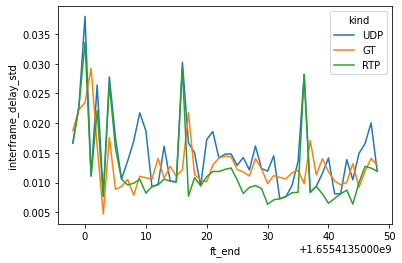

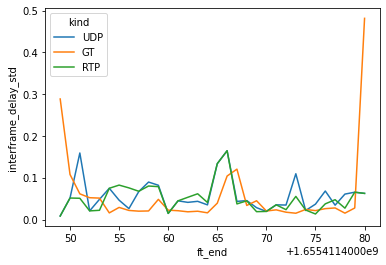

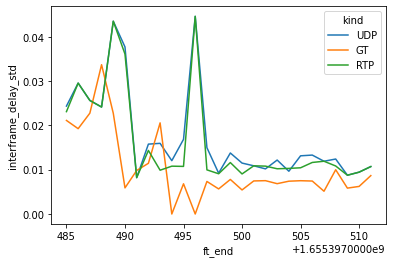

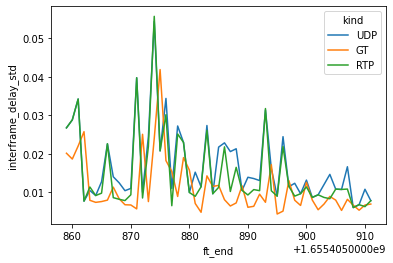

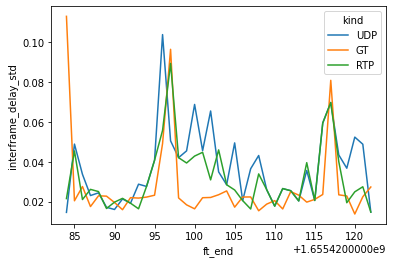

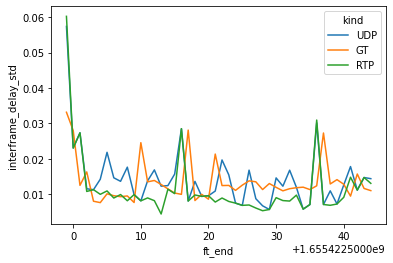

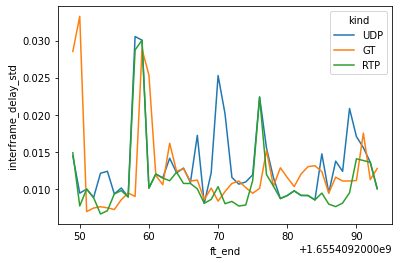

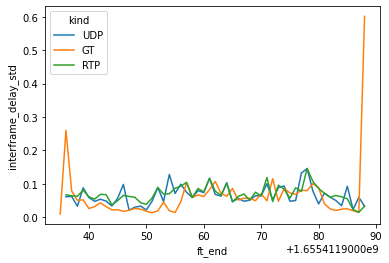

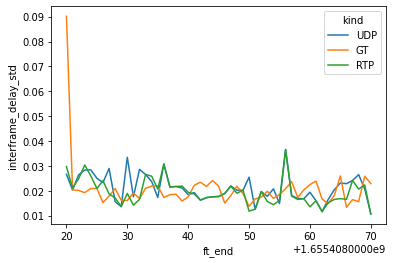

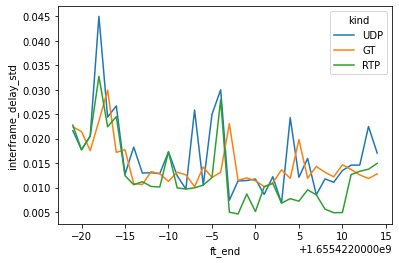

In [1239]:
i = 0

col_net = 'interframe_delay_std'
col_webrtc = col_map[col_net]
for k in test_files:
    df_udp = df_merge_udp[df_merge_udp["file"] == k]
    df_rtp = df_merge_rtp[df_merge_rtp["file"] == k]
    df1 = df_udp[["ft_end", col_net]]
    df1["kind"] = "UDP"
    df2 = df_udp[["ft_end", col_webrtc]].rename(columns={col_webrtc: col_net})
    print(df2.head(2))
    df2["kind"] = "GT"
    df3 = df_rtp[["ft_end", col_net]]
    df3["kind"] = "RTP"
    df = pd.concat([df1, df2, df3]).reset_index()
    plt.figure()
    sns.lineplot(x="ft_end", y=col_net, data=df, hue="kind")
    i += 1
    if i == 10:
        break

<AxesSubplot:ylabel='Proportion'>

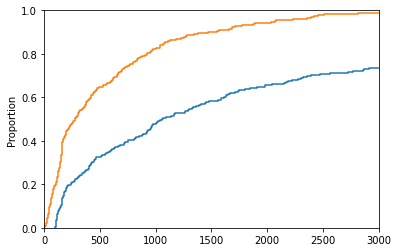

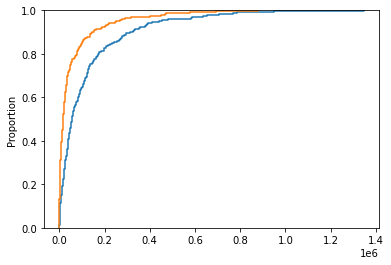

In [1157]:
BW_IDX = 0
BW_VAR_IDX = 1
files = list(file_map.keys())
bw_list = []
bw_var_list = []
rtt_list = []
rtt_var_list = []
for file in files:
    p = re.compile("(\d+)_(\d+)_(\d+)_(\d+)_(\d+)_(\d+).json")
    m = p.match(file)
    val_list = [int(m.group(i)) for i in range(1, 6)]
    bw_list.append(val_list[0])
    bw_var_list.append(val_list[1])
    rtt_list.append(val_list[2])
    rtt_var_list.append(val_list[3])
sns.ecdfplot(bw_list)
sns.ecdfplot(bw_var_list)
plt.xlim([0, 3000])
plt.figure()
sns.ecdfplot(rtt_list)
sns.ecdfplot(rtt_var_list)


In [1159]:
print(rtt_list)

[34634, 215048, 127382, 30632, 49292, 2059, 81751, 96408, 93870, 177304, 36342, 27933, 20919, 45123, 69622, 19008, 56808, 108576, 81725, 156209, 36529, 48335, 33297, 32690, 63792, 28787, 10015, 285267, 182734, 19401, 20613, 24706, 123736, 32588, 23811, 50352, 42244, 279243, 582394, 104861, 37094, 3054, 69046, 10637, 105982, 87606, 377918, 37867, 222101, 11408, 62654, 15551, 129369, 12269, 19466, 19536, 147968, 8122, 58018, 336032, 135441, 1345965, 68095, 212548, 32140, 86785, 154361, 8069, 51723, 38370, 199821, 48851, 8723, 64437, 128077, 5842, 90643, 87986, 28839, 296101, 14117, 349930, 334532, 27984, 20207, 114800, 436804, 706683, 22980, 160697, 60212, 20778, 174448, 43577, 134451, 133109, 23077, 51553, 53813, 151255, 327822, 652732, 270452, 90306, 41725, 48349, 1873, 137561, 9884, 454761, 39328, 61623, 79506, 43471, 50579, 42600, 3852, 52981, 588611, 438847, 127199, 385276, 37545, 116161, 662, 25963, 161992, 409910, 231080, 239906, 71991, 118987, 55987, 37868, 391656, 127546, 57496,

## Feature importance

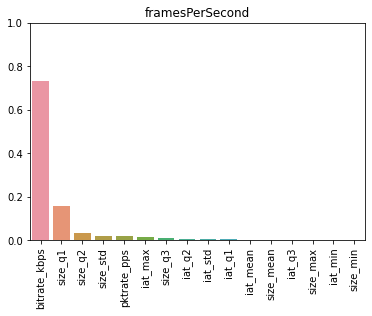

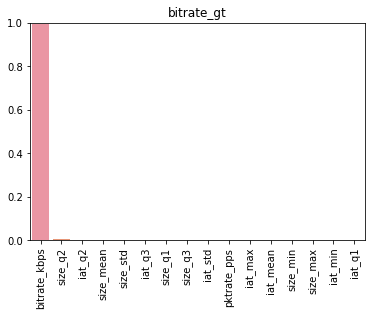

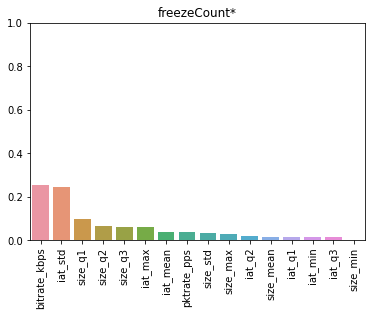

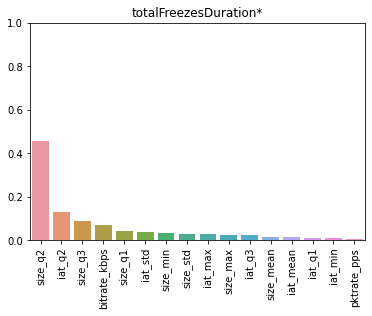

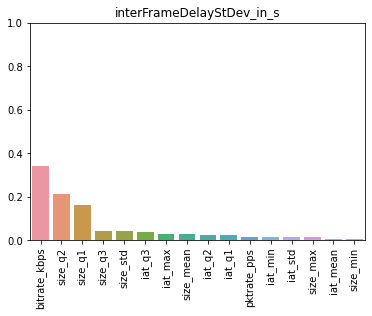

In [1229]:
vca = "Meet"
models = models_vca[vca]
cols_x = ['bitrate_kbps', 'pktrate_pps',
       'size_min', 'size_max', 'size_mean', 'size_std', 'size_q1', 'size_q2',
       'size_q3', 'iat_min', 'iat_max', 'iat_mean', 'iat_std', 'iat_q1',
       'iat_q2', 'iat_q3']
for k in models[1]:
    model = models[1][k]
    l = model.feature_importances_
    paired_l = [(cols_x[i], l[i]) for i in range(0, len(l))]
    sorted_l = sorted(paired_l, key=lambda x: x[1], reverse=True)
    plt.figure()
    sns.barplot(x=[x[0] for x in sorted_l], y=[x[1] for x in sorted_l])
    plt.title(k)
    plt.ylim([0, 1])
    plt.xticks(rotation=90)


## Error visualization

fps
bin_gt  kind 
25      RTP      786
        NetML    783
10      NetML    347
        RTP      334
5       NetML    197
        RTP      175
20      RTP       72
15      RTP       60
0       NetML     54
        RTP       48
15      NetML     48
20      NetML     40
30      NetML     36
        RTP       36
dtype: int64
bitrate
bin_gt  kind 
0       NetML    410
        RTP      358
2400    NetML    314
        RTP      314
200     RTP      217
        NetML    215
400     RTP      106
        NetML     92
600     RTP       91
1200    RTP       87
600     NetML     84
1200    NetML     81
1000    RTP       73
800     RTP       68
1000    NetML     63
800     NetML     60
1400    RTP       58
        NetML     58
1800    RTP       42
1600    RTP       41
1800    NetML     40
1600    NetML     33
2000    NetML     30
        RTP       30
2200    NetML     26
        RTP       26
2800    NetML      2
        RTP        2
2600    NetML      1
        RTP        1
dtype: int64


/data/tarun/miniconda3/envs/main/lib/python3.9/site-packages/seaborn/categorical.py:373: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
  ax.set_xlim(-.5, len(self.plot_data) - .5, auto=None)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


interframe_delay_std
bin_gt  kind 
0       NetML    1474
        RTP      1467
100     NetML      33
        RTP        19
200     NetML       2
        RTP         2
dtype: int64
freeze_count
bin_gt        kind 
=0            RTP      1456
              NetML    1426
(0.32, 0.68]  NetML      80
              RTP        58
>0.68         NetML       3
dtype: int64
freeze_dur
Series([], dtype: int64)


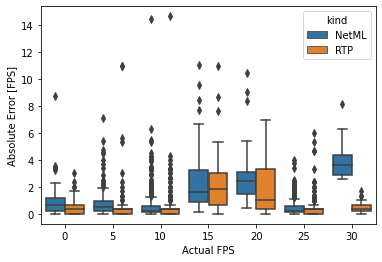

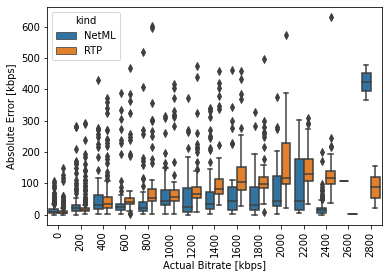

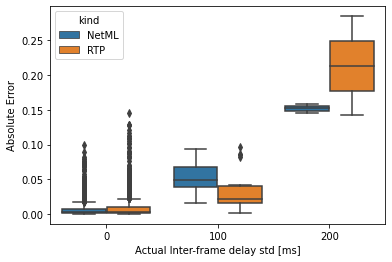

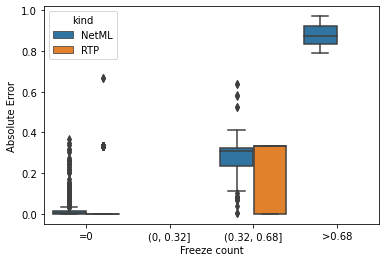

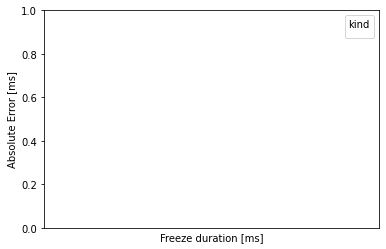

In [893]:
def get_col_bin(x, col):
    if col == "fps":
        bin_size = 5
        x_bin = x.apply(lambda t: int(t/bin_size)*bin_size)
        return x_bin
    elif col == "freeze_dur":
        rng_l  = [0.1*t for t in range(-1, 1, 10)]
        return pd.cut(x, rng_l, right=True)
    elif col == "freeze_count":
        return pd.cut(x, [-1, 0, 0.32, 0.68, 2], right=True, labels=['=0', "(0, 0.32]", "(0.32, 0.68]", ">0.68"])
    elif col == "bitrate":
        bin_size = 200
        x_bin = x.apply(lambda t: int(t/bin_size)*bin_size)
        return x_bin
    elif col == "interframe_delay_std":
        bin_size = 100
        x_ms = x.apply(lambda t: int(1000*t))
        x_bin = x_ms.apply(lambda t: int(t/bin_size)*bin_size)
        return x_bin
    else:
        return x
    

for col in ['fps', 'bitrate', 'interframe_delay_std', 'freeze_count', 'freeze_dur']:
    print(col)
    df_err = err_map[col]
    df_err["bin_gt"] = get_col_bin(df_err["actual"], col)
    df_err["error"] = df_err.apply(lambda x: abs(x["pred"] - x["actual"]), axis=1)
    print(df_err[["bin_gt", "kind"]].value_counts())
    plt.figure()
    sns.boxplot(data=df_err, x="bin_gt", y="error", hue="kind")
    
    if col == "fps":
        #plt.xlim([-0.5, 4.5])
        plt.xlabel("Actual FPS")
        plt.ylabel("Absolute Error [FPS]")
    elif col == "bitrate":
        #plt.xlim([-0.5, 4.5])
        plt.xlabel("Actual Bitrate [kbps]")
        plt.ylabel("Absolute Error [kbps]")
        plt.xticks(rotation=90)
    elif col == "interframe_delay_std":
        #plt.xlim([-0.5, 2.5])
        plt.xlabel("Actual Inter-frame delay std [ms]")
        plt.ylabel("Absolute Error")
    elif col == "freeze_dur":
        #plt.xlim([-0.5, 2.5])
        plt.xlabel("Freeze duration [ms]")
        plt.ylabel("Absolute Error [ms]")
    elif col == "freeze_count":
        plt.xlabel("Freeze count")
        plt.ylabel("Absolute Error")

## RTP Header analysis

In [ ]:
ptype_list = ['111', '98']
df_media = df_rtp[df_rtp["rtp.p_type"] == '98']
df_media = df_media.sort_values(["rtp.timestamp"])
df_media['diff'] = df_media['rtp.timestamp'].diff()
df_media['relative_diff'] = df_media['frame.time_relative'].diff()

In [303]:
get_sampling_rate(f"{dirname}/webrtc/{k}")

[90000]

In [ ]:
i = 0
for k in file_map:
    df_rtp = file_map[k]['rtp']
    df_video = df_rtp[df_rtp["rtp.p_type"] == "98"]
    df_video = df_video.groupby("rtp.timestamp").agg({"udp.length": "sum", "frame.time_epoch": ["min", "max"]}).reset_index()
    df_video.columns = ['_'.join(col).strip('_') for col in df_video.columns.values]
    df_video = df_video.rename(columns={'udp.length_sum': f'frame_size'})
    df_video["recv_time_rel"] = df_video["frame.time_epoch_max"] - df_video["frame.time_epoch_max"].min()
    df_video["play_time_rel"] = (df_video["rtp.timestamp"] - df_video["rtp.timestamp"].min()) / 90000
    df_video["diff"] = df_video["recv_time_rel"] - df_video["play_time_rel"]
    #df_video[["recv_time_rel", "play_time_rel", "diff"]].head(150)

    df_video["frame_dur"] = df_video["frame.time_epoch_max"].diff()
    df_video["avg_frame_dur"] = df_video["frame_dur"].rolling(30).mean()
    df_video = df_video.dropna()
    df_video["is_freeze"] = df_video.apply(is_freeze, axis=1)
    df_video["freeze_dur"] = df_video.apply(get_freeze_dur, axis=1)

    df_video[f"ft_end"] = df_video['frame.time_epoch_max'].apply(lambda x: int(x))
    df_grp = df_video.groupby("ft_end").agg({"is_freeze": "sum", "freeze_dur": "sum"}).reset_index()


    df_webrtc = file_map[k]['webrtc']
    df_webrtc["ts_diff"] = df_webrtc["ts"] - df_webrtc["ts"].min()
    df_webrtc["framesDroppedDiff"] = df_webrtc["framesDropped"].diff()
    
    df_merge = pd.merge(df_grp, df_webrtc, left_on = "ft_end", right_on="ts")
    df_merge["ts"] = df_merge["ts"] - df_merge["ts"].min()
    df_merge[["ts", "is_freeze", "freezeCount*", "freeze_dur", "totalFreezesDuration*",  "framesDroppedDiff", "totalFramesDuration*"]]
    
    #print(k, df_merge["totalFreezesDuration*"].sum(), df_merge["freeze_dur"].sum())
    print(df_merge[["ts_diff", "is_freeze", "freezeCount*", "totalFreezesDuration*", "freeze_dur", "framesDropped"]].head(100))
    
    plt.figure()
    sns.lineplot(data=df_video, x="recv_time_rel", y="diff")
    sns.lineplot(data=df_webrtc, x="ts_diff", y="framesDroppedDiff")

    
    
    i += 1
    if i == 5:
        break


In [ ]:
df_rtp = file_map[k]['rtp']
df_video = df_rtp[df_rtp["rtp.p_type"] == "98"]
df_video = df_video.groupby("rtp.timestamp").agg({"udp.length": "sum", "frame.time_epoch": ["min", "max"]}).reset_index()
df_video.columns = ['_'.join(col).strip('_') for col in df_video.columns.values]
df_video = df_video.rename(columns={'udp.length_sum': f'frame_size'})
df_video["frame_dur"] = df_video["frame.time_epoch_max"].diff()
df_video["avg_frame_dur"] = df_video["frame_dur"].rolling(30).mean()
df_video = df_video.dropna()
df_video["is_freeze"] = df_video.apply(is_freeze, axis=1)
df_video["freeze_dur"] = df_video.apply(get_freeze_dur, axis=1)

df_video[f"ft_end"] = df_video['frame.time_epoch_max'].apply(lambda x: int(x))
df_grp = df_video.groupby("ft_end").agg({"is_freeze": "count", "freeze_dur": "sum"}).reset_index()

df_webrtc = file_map[k]['webrtc']
df_merge = pd.merge(df_grp, df_webrtc, left_on = "ft_end", right_on="ts")
df_merge["ts"] = df_merge["ts"] - df_merge["ts"].min()
df_merge[["ts", "is_freeze", "freezeCount*", "freeze_dur", "totalFreezesDuration*",  "framesDropped", "totalFramesDuration*"]]

In [696]:
for col_y in cols_y:
    for i in range(0, len(result_map[col_y])):
        print(col_y, result_map[col_y][i][0], '%.2f' % result_map[col_y][i][1])

framesPerSecond 1 2.50
framesPerSecond 2 2.11
framesPerSecond 3 2.04
framesPerSecond 4 1.65
framesPerSecond 5 1.80
framesPerSecond 6 1.65
framesPerSecond 7 1.49
framesPerSecond 8 1.76
framesPerSecond 9 1.54
[bytesReceived_in_bits/s] 1 101548.77
[bytesReceived_in_bits/s] 2 99156.10
[bytesReceived_in_bits/s] 3 79365.54
[bytesReceived_in_bits/s] 4 68283.72
[bytesReceived_in_bits/s] 5 86402.26
[bytesReceived_in_bits/s] 6 77163.65
[bytesReceived_in_bits/s] 7 72078.28
[bytesReceived_in_bits/s] 8 51599.69
[bytesReceived_in_bits/s] 9 64724.84
freezeCount* 1 0.14
freezeCount* 2 0.12
freezeCount* 3 0.12
freezeCount* 4 0.11
freezeCount* 5 0.10
freezeCount* 6 0.10
freezeCount* 7 0.09
freezeCount* 8 0.09
freezeCount* 9 0.08
totalFreezesDuration* 1 0.09
totalFreezesDuration* 2 0.08
totalFreezesDuration* 3 0.08
totalFreezesDuration* 4 0.11
totalFreezesDuration* 5 0.10
totalFreezesDuration* 6 0.08
totalFreezesDuration* 7 0.09
totalFreezesDuration* 8 0.07
totalFreezesDuration* 9 0.07
[interFrameDelaySt

## RTP Lag

In [58]:
webrtc_cols = ["framesPerSecond","lastPacketReceivedTimestamp","ts", "framesReceived"]
dfs = []
i = 0
for k in file_map:
    df_video = file_map[k]['rtp']
    df_video = df_video.groupby("rtp.timestamp").agg({"udp.length": "sum", "frame.time_epoch": ["min", "max"]}).reset_index()
    df_video.columns = ['_'.join(col).strip('_') for col in df_video.columns.values]
    df_list = []
    for i in range(0, 10):
        delta = 0.1*i
        df_video[f"ft_end"] = df_video['frame.time_epoch_max'].apply(lambda x: int(x+delta))
        df_grp = df_video.groupby("ft_end")["udp.length_sum"].agg("count").reset_index()
        delta = "%.1f" % delta
        df_grp = df_grp.rename(columns={'udp.length_sum': f'fps_{delta}'})
        df_list.append(df_grp)
    df_merge = df_list[0]
    for i in range(1, len(df_list)):
        df_merge = pd.merge(df_merge, df_list[i], on="ft_end")
    df_webrtc = file_map[k]['webrtc']
    df_webrtc = df_webrtc.drop(df_webrtc.index[:2], axis=0).drop(df_webrtc.index[-2:], axis=0)
    df_webrtc = df_webrtc[webrtc_cols]
    df_merge = pd.merge(df_merge, df_webrtc, left_on="ft_end", right_on="ts")
    df_merge["file"] = k
    dfs.append(df_merge)

## Non-RTP baseline

In [711]:
df_list = []
for k in file_map:
    df = file_map[k]["pcap"]
    df["file"] = k
    df_list.append(df)
df_net = pd.concat(df_list).reset_index()

In [717]:
df_rtx = df_net[df_net["rtp.p_type"] == 121]
df_rtx[df_rtx["udp.length"] != 304]

,index,frame.time_relative,frame.time_epoch,ip.src,ip.dst,ip.proto,ip.len,udp.srcport,udp.dstport,udp.length,...,rtcp.pt,rtcp.senderssrc,rtcp.ssrc.high_seq,rtcp.ssrc.dlsr,rtcp.psfb.fmt,rtcp.rtpfb.fmt,rtcp.sender.octetcount,is_rtp,time_win,file
17,1889,35.86,1654119300.45,52.115.142.181,192.168.1.107,17.00,214.00,3480.00,61498.00,194.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1654119300,393_223_199821_99544_32_1654119261.json
27,1927,36.11,1654119300.70,52.115.142.181,192.168.1.107,17.00,1105.00,3480.00,61498.00,1085.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1654119300,393_223_199821_99544_32_1654119261.json
28,1930,36.13,1654119300.72,52.115.142.181,192.168.1.107,17.00,1106.00,3480.00,61498.00,1086.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1654119300,393_223_199821_99544_32_1654119261.json
42,1982,36.50,1654119301.09,52.115.142.181,192.168.1.107,17.00,319.00,3480.00,61498.00,299.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1654119301,393_223_199821_99544_32_1654119261.json
86,2194,38.00,1654119302.59,52.115.142.181,192.168.1.107,17.00,192.00,3480.00,61498.00,172.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1654119302,393_223_199821_99544_32_1654119261.json
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1559438,8323,72.62,1654128974.01,52.115.142.181,192.168.1.107,17.00,1140.00,3480.00,63322.00,1120.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1654128974,977_536_115541_11444_39_1654128898.json
1559467,8409,73.01,1654128974.40,52.115.142.181,192.168.1.107,17.00,107.00,3480.00,63322.00,87.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1654128974,977_536_115541_11444_39_1654128898.json
1559883,9156,77.16,1654128978.55,52.115.142.181,192.168.1.107,17.00,203.00,3480.00,63322.00,183.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1654128978,977_536_115541_11444_39_1654128898.json
1560545,10295,83.12,1654128984.52,52.115.142.181,192.168.1.107,17.00,143.00,3480.00,63322.00,123.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1654128984,977_536_115541_11444_39_1654128898.json


In [ ]:
pd.options.display.max_rows = 2000
cols= ['frame.time_relative','frame.time_epoch','ip.src','ip.dst','ip.proto','ip.len','udp.srcport','udp.dstport', 'udp.length','rtp.ssrc','rtp.timestamp','rtp.seq','rtp.p_type']
df_net[df_net["file"] == "393_223_199821_99544_32_1654119261.json"][cols]

<AxesSubplot:xlabel='udp.length', ylabel='Proportion'>

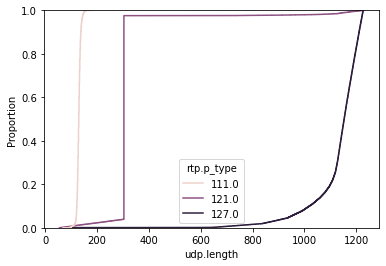

In [709]:
df_net["rtp.p_type"].value_counts()
sns.ecdfplot(data=df_net, x="udp.length", hue="rtp.p_type")


## Error visualization

In [ ]:
import matplotlib.pyplot as plt
interval = 1
df_pred_ml = pd.DataFrame(pred[interval])
df_pred_ml["type"] = "ML"
df_pred_rtp = pd.DataFrame(pred_rtp[interval])
df_pred_rtp["type"] = "RTP"
df_pred = pd.concat([df_pred_ml, df_pred_rtp]).reset_index()
 
sns.boxplot(x=1, y="abs_error", data=df_pred, hue="type", showfliers=False, palette='Accent')
t = plt.xticks(rotation=90)
plt.xlabel("Actual FPS")
plt.ylabel("Absolute Error FPS")

In [ ]:
dfa 

In [263]:
#df_pred[1].value_counts()

In [505]:
webrtc_cols = ["framesPerSecond","lastPacketReceivedTimestamp","ts", "framesReceived", '[bytesReceived_in_bits/s]', 'freezeCount*', 'totalFreezesDuration*']
dfs = []
i = 0
audio_size = 100
for interval in range(1, 2):
    for k in file_map:
        df_net = file_map[k]['pcap']
        df_net = df_net[df_net['udp.length'] > audio_size]
        df_netml = get_net_stats(df_net, interval=interval)
        df_webrtc = file_map[k]['webrtc']
        df_webrtc = df_webrtc.drop(df_webrtc.index[:2], axis=0).drop(df_webrtc.index[-2:], axis=0)
        df_webrtc = df_webrtc[webrtc_cols]
        df_webrtc["ts"] = df_webrtc["ts"].apply(lambda x: int(x/interval)*interval)
        df_webrtc = df_webrtc.groupby(["ts"])[cols_y].agg(np.mean)
        df_merge = pd.merge(df_netml, df_webrtc, left_on="time_win", right_on="ts")
        df_merge["file"] = k
        dfs.append(df_merge)
    df_merge = pd.concat(dfs).reset_index(drop=True)
    df_small = df_merge[cols_x + cols_y]
    df_small = df_small[~pd.isna(df_small[col_y])]
    X = df_small[cols_x].to_numpy()
    y = df_small[col_y]
    regr = RandomForestRegressor(max_depth=5, random_state=0)
    scores = cross_val_score(regr, X, y, scoring='neg_root_mean_squared_error', cv=5)
    print(f"{col_y}::: Interval: {interval}, Average score: {scores.mean()} and Std dev: {scores.std()}")

totalFreezesDuration*::: Interval: 1, Average score: -0.11122121756098342 and Std dev: 0.03213207629132573


## Process data

In [522]:
#df_net["iat"] = df_net["frame.time_relative"].diff()
df_net1 = df_net[df_net["rtp.p_type"] == 127]

28501108.00    9
28504549.00    1
Name: rtp.timestamp, dtype: int64


<AxesSubplot:xlabel='frame.time_relative', ylabel='udp.length'>

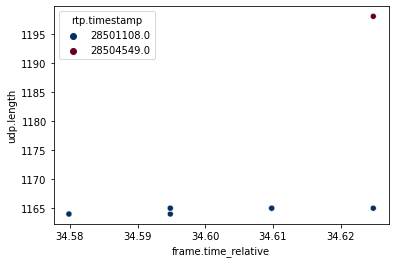

In [524]:
df_small = df_net1.head(10)
print(df_small["rtp.timestamp"].value_counts())
sns.scatterplot(data=df_small, x="frame.time_relative", y="udp.length", hue="rtp.timestamp", palette="RdBu_r")

In [123]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
df_small[["frame.time_relative", "udp.length", "rtp.timestamp", "iat"]]

,frame.time_relative,udp.length,rtp.timestamp,iat
1038,12.57,266.00,0.00,NaN
1051,12.66,1094.00,3366936477.00,0.09
1061,12.74,1099.00,3366936477.00,0.08
1074,12.83,1099.00,3366936477.00,0.09
1083,12.91,1099.00,3366936477.00,0.09
1099,13.04,1099.00,3366936477.00,0.13
1117,13.15,1095.00,3366936477.00,0.11
1119,13.18,429.00,3366941427.00,0.04
1131,13.25,587.00,3366945477.00,0.07
1144,13.33,680.00,3366950607.00,0.08


## Data visualization

<AxesSubplot:xlabel='framesPerSecond', ylabel='Proportion'>

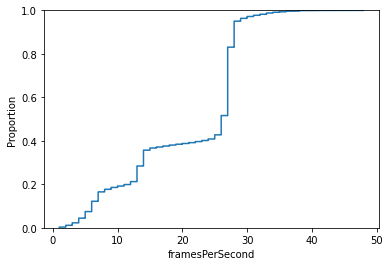

In [506]:
sns.ecdfplot(df_merge["framesPerSecond"])

<AxesSubplot:xlabel='[bytesReceived_in_bits/s]', ylabel='Proportion'>

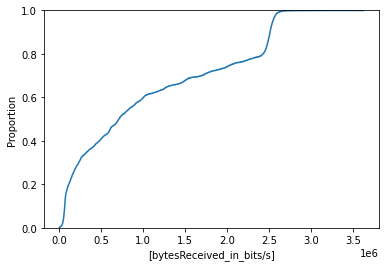

In [507]:
sns.ecdfplot(df_merge["[bytesReceived_in_bits/s]"])

<AxesSubplot:xlabel='freezeCount*', ylabel='Proportion'>

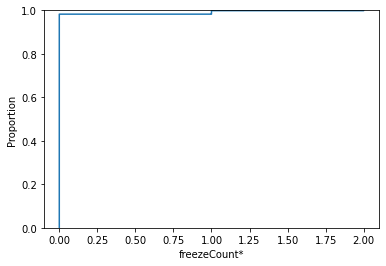

In [508]:
sns.ecdfplot(df_merge["freezeCount*"])

<AxesSubplot:xlabel='totalFreezesDuration*', ylabel='Proportion'>

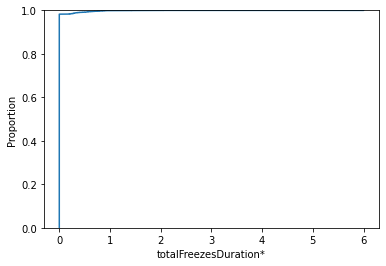

In [509]:
sns.ecdfplot(df_merge["totalFreezesDuration*"])

## Machine learning

In [296]:
df_merge.columns

Index(['index', 'ts', 'ssrc', 'lastPacketReceivedTimestamp', 'framesPerSecond',
       '[bytesReceived_in_bits/s]', '[codec]', 'packetsLost', 'framesDropped',
       'trackIdentifier', 'freezeCount*', 'totalFreezesDuration*',
       'totalFramesDuration*', 'time_win', 'ip.src', 'ip.dst', 'udp.srcport',
       'udp.dstport', 'is_rtp', 'dur', 'dur1', 'bitrate_kbps', 'pktrate_pps',
       'size_min', 'size_max', 'size_mean', 'size_std', 'size_q1', 'size_q2',
       'size_q3', 'iat_min', 'iat_max', 'iat_mean', 'iat_std', 'iat_q1',
       'iat_q2', 'iat_q3', 'filename'],
      dtype='object')

In [370]:
df_small.columns

Index(['bitrate_kbps', 'pktrate_pps', 'size_min', 'size_max', 'size_mean',
       'size_std', 'size_q1', 'size_q2', 'size_q3', 'iat_min', 'iat_max',
       'iat_mean', 'iat_std', 'iat_q1', 'iat_q2', 'iat_q3', 'framesPerSecond',
       '[bytesReceived_in_bits/s]', 'freezeCount*', 'totalFreezesDuration*'],
      dtype='object')

## Using RF Regressor

In [313]:



for col_y in cols_y:


framesPerSecond: Average score: -2.2851505309287776 and Std dev: 0.4900076679535156
[bytesReceived_in_bits/s]: Average score: -44.580664023575096 and Std dev: 5.880967434764467
freezeCount*: Average score: -0.2083242176964415 and Std dev: 0.025171003134783952
totalFreezesDuration*: Average score: -0.1496497196734891 and Std dev: 0.10092427423111075


<AxesSubplot:xlabel='size_q2', ylabel='Proportion'>

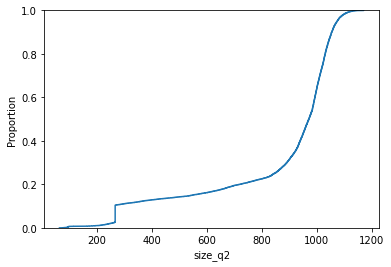

In [416]:
sns.ecdfplot(df_small["size_q2"])

In [372]:
from sklearn.model_selection import train_test_split
importance_map = {}
df_importance = pd.DataFrame()
models = {}
data = {}
for col_y in cols_y:
    y = df_small[col_y]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    data[col_y] = [X_train, y_train, X_test, y_test]
    regr = RandomForestRegressor(max_depth=5, random_state=0)
    regr.fit(X_train, y_train)
    models[col_y] = regr
    df_importance[col_y] = pd.Series(regr.feature_importances_, index=cols_x)
    #importance_map[col_y] = {cols_x[i]: regr.feature_importances_[i] for i in range(0, len(cols_x))}

In [382]:
col_y = "framesPerSecond"


(2621    21.00000
 4063    17.00000
 12499   23.00000
 7105    19.00000
 9486    22.00000
           ...   
 7297    21.00000
 8994    19.00000
 12967   22.00000
 4827    22.00000
 3194    22.00000
 Name: framesPerSecond, Length: 4896, dtype: float64,
 array([[2.21080000e+02, 4.10000000e+01, 5.10000000e+01, ...,
         1.38530135e-02, 2.25188732e-02, 3.23063135e-02],
        [1.92232000e+02, 3.50000000e+01, 5.10000000e+01, ...,
         1.75948143e-02, 2.95214653e-02, 3.69126797e-02],
        [4.11120000e+02, 6.30000000e+01, 5.10000000e+01, ...,
         9.73421335e-03, 1.34830475e-02, 1.50178671e-02],
        ...,
        [4.83168000e+02, 6.30000000e+01, 5.10000000e+01, ...,
         4.13149595e-03, 5.71596622e-03, 2.26766467e-02],
        [3.87720000e+02, 5.70000000e+01, 5.10000000e+01, ...,
         5.76204062e-03, 8.01050663e-03, 2.67889500e-02],
        [1.71664000e+02, 3.30000000e+01, 5.10000000e+01, ...,
         1.59392953e-02, 2.41038799e-02, 4.23133373e-02]]))

In [402]:
print(y_predict[i])

21.59417614563925


In [410]:
col_y = "totalFreezesDuration*"
y_predict = models[col_y].predict(data[col_y][2])
y_actual = data[col_y][3].reset_index()[col_y].to_list()

df_scatter = pd.DataFrame()
df_scatter["predict"] = y_predict
df_scatter["actual"] = y_actual
from sklearn.metrics import mean_squared_error

rms = np.sqrt(((y_predict - y_actual) ** 2))
df_scatter["rms"] = rms


TypeError: title() missing 1 required positional argument: 'label'

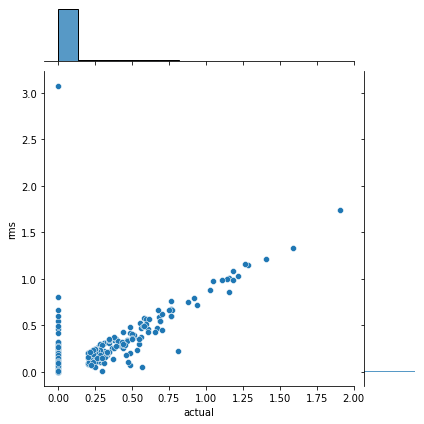

In [414]:
#sns.boxplot(data=df_scatter, x="actual", y="rms")
sns.jointplot(data=df_scatter, x="actual", y="predict")
plt.xticks(rotation=90)
plt.title()

In [389]:
df_scatter["actual"]

0      21.00000
1      17.00000
2      23.00000
3      19.00000
4      22.00000
         ...   
4891   21.00000
4892   19.00000
4893   22.00000
4894   22.00000
4895   22.00000
Name: actual, Length: 4896, dtype: float64

,index,framesPerSecond
0,2621,21.00000
1,4063,17.00000
2,12499,23.00000
3,7105,19.00000
4,9486,22.00000
...,...,...
4891,7297,21.00000
4892,8994,19.00000
4893,12967,22.00000
4894,4827,22.00000


In [384]:
df_scatter

,predict
0,21.59418
1,21.59418
2,21.02351
3,20.48366
4,21.64498
...,...
4891,21.59418
4892,21.57146
4893,21.64498
4894,21.64498


## Find lag 

In [ ]:
import matplotlib.pyplot as plt
from scipy import signal
import numpy as np


def lag_finder(y1, y2, sr):
    n = len(y1)

    corr = signal.correlate(y2, y1, mode='same') / np.sqrt(signal.correlate(y1, y1, mode='same')[int(n/2)] * signal.correlate(y2, y2, mode='same')[int(n/2)])

    delay_arr = np.linspace(-0.5*n/sr, 0.5*n/sr, n)
    delay = delay_arr[np.argmax(corr)]
    print('y2 is ' + str(delay) + ' behind y1')

    plt.figure()
    plt.plot(delay_arr, corr)
    plt.title('Lag: ' + str(np.round(delay, 3)) + ' s')
    plt.xlabel('Lag')
    plt.ylabel('Correlation coeff')
    plt.show()

In [236]:
#for filename in file_map:
#    df_

2423

         time_win          ip.src          ip.dst  udp.srcport  udp.dstport  \
0      1651708147  108.177.111.94   192.168.1.107    443.00000  65105.00000   
1      1651708147   192.168.1.107  108.177.111.94  65105.00000    443.00000   
2      1651708147   192.168.1.107   35.227.242.83  62542.00000    443.00000   
3      1651708147   35.227.242.83   192.168.1.107    443.00000  62542.00000   
4      1651708148  108.177.111.94   192.168.1.107    443.00000  65105.00000   
...           ...             ...             ...          ...          ...   
15090  1651710585   192.168.1.107     224.0.0.251   5353.00000   5353.00000   
15091  1651710586  142.250.82.185   192.168.1.107   3478.00000  60102.00000   
15092  1651710586  142.250.82.185   192.168.1.107   3478.00000  60102.00000   
15093  1651710586   192.168.1.107  142.250.82.185  60102.00000   3478.00000   
15094  1651710586   192.168.1.107  142.250.82.185  60102.00000   3478.00000   

       is_rtp  dur    dur1  bitrate_kbps  pktrate_p

<AxesSubplot:xlabel='ts', ylabel='[bytesReceived_in_bits/s]'>

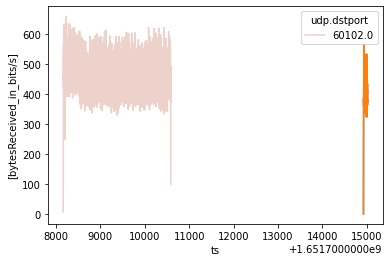

In [225]:
import seaborn as sns
import matplotlib.pyplot as plt





In [199]:
df_net["is_rtp"]

0      0
1      0
2      0
3      0
4      0
      ..
836    0
837    0
838    0
839    0
840    0
Name: is_rtp, Length: 841, dtype: int64

In [185]:
df1

,ts,ssrc,lastPacketReceivedTimestamp,framesPerSecond,[bytesReceived_in_bits/s],[codec],packetsLost,framesDropped,trackIdentifier,freezeCount*,totalFreezesDuration*
0,1651711955,2632058081,NaN,NaN,0.00000,NaN,0,0,64e686d1-eb7f-4cc4-98bc-d634e2332598,0,0
1,1651711956,2632058081,1651711956.68100,19.00000,250.92854,"VP9 (98, profile-id=0)",0,0,64e686d1-eb7f-4cc4-98bc-d634e2332598,0,0
2,1651711957,2632058081,1651711957.68600,23.00000,313.84247,"VP9 (98, profile-id=0)",0,0,64e686d1-eb7f-4cc4-98bc-d634e2332598,0,0
3,1651711958,2632058081,1651711958.63900,22.00000,360.51775,"VP9 (98, profile-id=0)",0,0,64e686d1-eb7f-4cc4-98bc-d634e2332598,0,0
4,1651711959,2632058081,1651711959.65000,22.00000,389.97828,"VP9 (98, profile-id=0)",0,0,64e686d1-eb7f-4cc4-98bc-d634e2332598,0,0
...,...,...,...,...,...,...,...,...,...,...,...
80,1651712035,2632058081,1651712035.69100,20.00000,373.26988,"VP9 (98, profile-id=0)",0,0,64e686d1-eb7f-4cc4-98bc-d634e2332598,0,0
81,1651712036,2632058081,1651712036.77200,20.00000,449.88618,"VP9 (98, profile-id=0)",0,0,64e686d1-eb7f-4cc4-98bc-d634e2332598,0,0
82,1651712037,2632058081,1651712037.74800,22.00000,421.40227,"VP9 (98, profile-id=0)",0,0,64e686d1-eb7f-4cc4-98bc-d634e2332598,0,0
83,1651712038,2632058081,1651712038.75100,22.00000,389.00206,"VP9 (98, profile-id=0)",0,0,64e686d1-eb7f-4cc4-98bc-d634e2332598,0,0


In [95]:
                
print(get_active_stream(webRTC_stats))
    

{'2632058081': 1}


In [75]:


output = extractWebRTC(webRTC_stats,wantedStats)


{'2632058081': 'RTCMediaStreamTrack_receiver_6'}


In [51]:
df_grp["iat_stats"]

0      [0.0, 0.027181999999999998, 0.0080132000000000...
1                        [0, 0, 0.0, 0.0, 0.0, 0.0, 0.0]
2      [9.800000000000086e-05, 0.040268, 0.01373075, ...
3      [0.0, 0.04292399999999996, 0.02065359999999998...
4                        [0, 0, 0.0, 0.0, 0.0, 0.0, 0.0]
                             ...                        
849                      [0, 0, 0.0, 0.0, 0.0, 0.0, 0.0]
850    [0.0, 0.021816999999998643, 0.0076969464285718...
851    [0.00027399999999033753, 0.030859000000020842,...
852    [7.400000001211993e-05, 0.020361999999977343, ...
853    [5.5000000003246896e-05, 0.03297900000001164, ...
Name: iat_stats, Length: 854, dtype: object

In [41]:
df_grp.head(1)

,time_win,ip.src,ip.dst,udp.srcport,udp.dstport,frame.time_relative,udp.length,dur,size,num,bitrate_kbps,pktrate_pps,stats
0,0,172.253.115.103,192.168.1.107,443.0,55837.0,"[0.024866, 0.052048, 0.052048, 0.054507, 0.054...","[36.0, 1254.0, 540.0, 34.0, 50.0, 34.0]",0.040066,1948.0,6,388.958219,149.752908,"[34.0, 1254.0, 324.6666666666667, 454.19770536..."


In [31]:
df.columns

Index(['frame.time_relative', 'frame.time_epoch', 'ip.src', 'ip.dst',
       'ip.proto', 'ip.len', 'udp.srcport', 'udp.dstport', 'udp.length',
       'rtp.ssrc', 'rtp.timestamp', 'rtp.seq', 'rtp.p_type', 'rtp.marker',
       'rtp.padding', 'rtp.ext', 'rtp.ext.len', 'rtcp.pt', 'rtcp.senderssrc',
       'rtcp.ssrc.high_seq', 'rtcp.ssrc.dlsr', 'rtcp.psfb.fmt',
       'rtcp.rtpfb.fmt', 'rtcp.sender.octetcount'],
      dtype='object')